In [1]:
from typing import List
from typing import Tuple
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

from tqdm import tqdm

sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle':'--'})

# Linear regression

Linear regression is a statistical method and a fundamental type of predictive analytical model used to describe the relationship between a dependent variable and one or more independent variables. In this class, we will use the "Auto MPG" dataset to learn and practice linear regression.

## The data

The "Auto MPG" dataset is one of the classic datasets available in the UCI Machine Learning Repository. It contains city-cycle fuel consumption estimates for various automobiles produced in the 1970s and 1980s, making it a commonly used dataset for regression analysis tasks in machine learning.

### Data Set Information:

The data concerns city-cycle fuel consumption in miles per gallon (MPG) to be predicted in terms of 3 multivalued discrete and 5 continuous attributes.

* mpg: continuous
* cylinders: multi-valued discrete
* displacement: continuous
* horsepower: continuous
* weight: continuous
* acceleration: continuous
* model year: multi-valued discrete
* origin: multi-valued discrete
* car name: string (unique for each instance)

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/changyaochen/MECE4520/master/data/auto_mpg.csv")
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino


## Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) refers to the process of visually and analytically inspecting data to uncover its main characteristics, often using statistical graphics, plots, and information tables. EDA is essential in data science, and is a fundamental step before proceeding to more advanced machine learning or statistical modeling, as it helps analysts and researchers understand the nature of the data, its structure, anomalies, patterns, and relationships.

EDA is often an iterative process: as you discover one feature or pattern in your data, it might lead you to look for other related features or patterns. Below, we will use the "Auto MPG" dataset as an example.

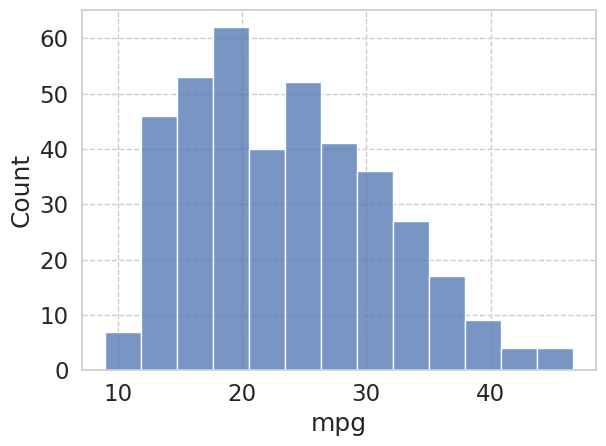

In [3]:
# distribution of the dependent variable
sns.histplot(x="mpg", data=data)
plt.tight_layout()

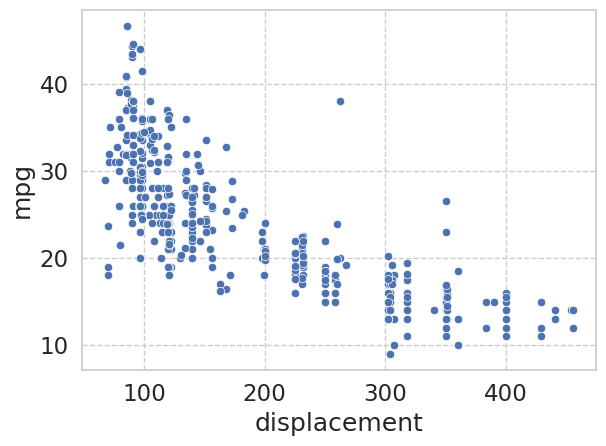

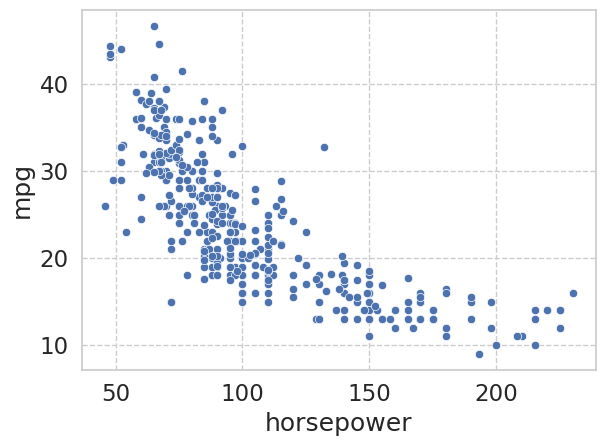

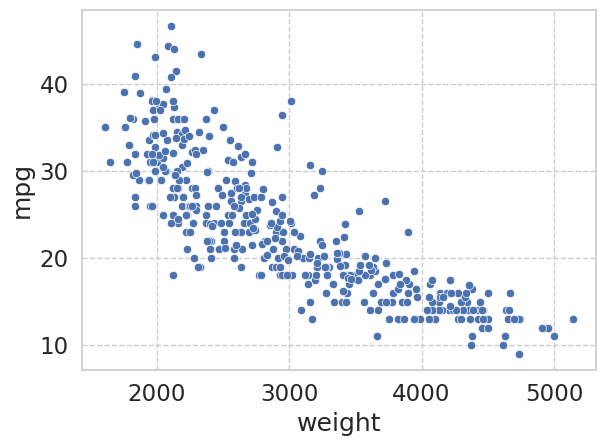

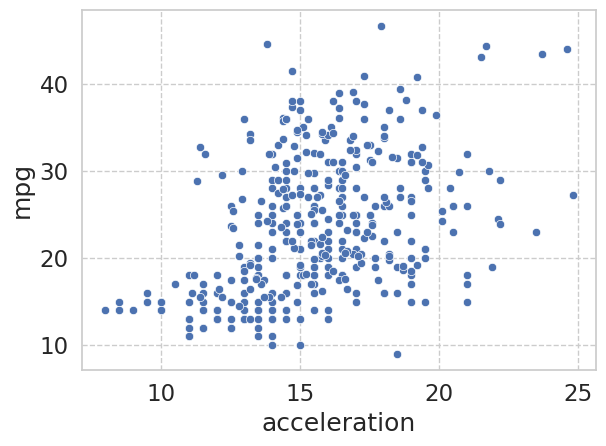

In [4]:
# correlations
continuous_variables = [
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
]

for variable in continuous_variables:
    plt.figure()
    sns.scatterplot(x=variable, y="mpg", data=data)
    plt.tight_layout()

## Simple linear regression

Simple linear regression refers to the special case of linear regression where there is only a single independent variable. Namely, it takes the form of:
$$y = \beta_0 + \beta_1 x,$$
where $y$ is the dependent variable, and $x$ is the single independent variable. The goal of the linear regression is to find the best values for the intercept $\beta_0$, and the slope $\beta_1$.

Below we will use the "Auto MPG" dataset as an example.

beta_0 is: 46.3174
beta_1 is: -0.0077
R-square is: 0.6918


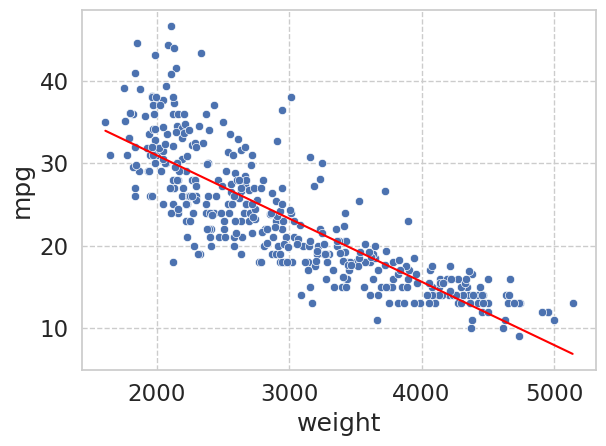

In [5]:
y = data["mpg"]
x = data["weight"]

def simple_linear_regression(
    x: Union[List, np.ndarray, pd.Series], 
    y: Union[List, np.ndarray, pd.Series]) -> Tuple[float, float]:
    """Return the intercept and slope of a simple linear regression."""
    beta_1 = np.cov(x, y)[0][1] / np.cov(x, x)[0][1]
    beta_0 = np.mean(y) - beta_1 * np.mean(x)
    
    return beta_0, beta_1

beta_0, beta_1 = simple_linear_regression(x=x, y=y)

# calculate R^2
y_pred = beta_0 + beta_1 * x
SST = np.sum(np.square(y - np.mean(y)))
residual = y - y_pred
SSE = np.sum(np.square(residual))
r2 = 1 - SSE / SST

print(f"beta_0 is: {beta_0:5.4f}")
print(f"beta_1 is: {beta_1:5.4f}")
print(f"R-square is: {r2:5.4f}")

plt.figure()
x_range = np.linspace(start=np.min(x), stop=np.max(x), num=100)
sns.scatterplot(x="weight", y="mpg", data=data)
sns.lineplot(x=x_range, y=(beta_0 + beta_1 * x_range), color="red")
plt.tight_layout()

Equally important to, if not more important than, the model fitting, is the model/error analysis. Here we will demonstrate a simple residual analysis, to examine if its distirubtion agrees with our (normality) assumption> 

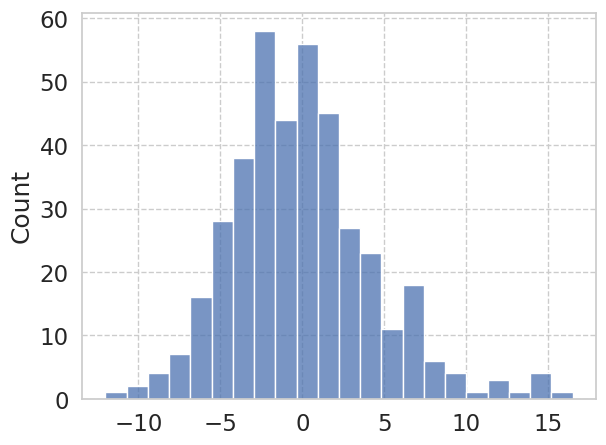

In [6]:
# residual analysis
plt.figure()
sns.histplot(residual)
plt.tight_layout()
plt.show()

An important aspect in linear regression is that, the fitted parameters (_e.g._, intercept, slope), are just point estimates of the population parameter. Here the "population" refers to the underlying stochastic process that generates the observed data. 

Below, we will run a simulation: in each trial, we only sample 20% from the full observation, and run the simple linear regression. We will repeat the trial 100 times. This is to show that, the fitting parameters is a random variable: it depends on the exact data that is used. Therefore, as a random variable, we need to pay attention to its bias and variance.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 58.61it/s]


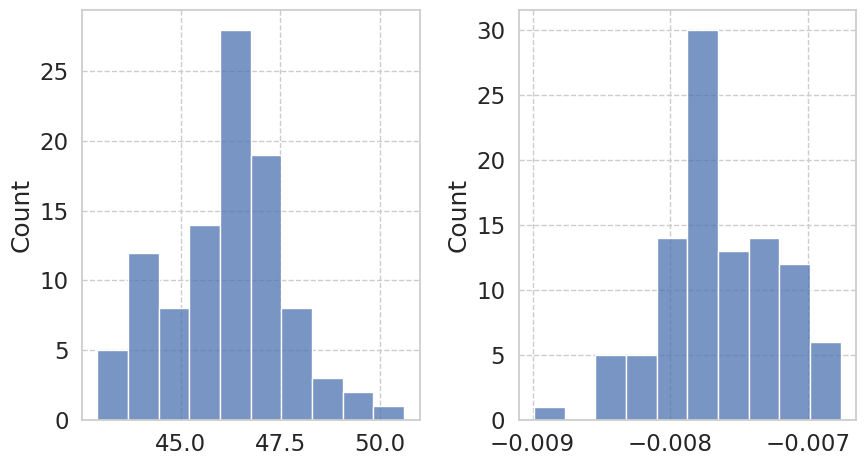

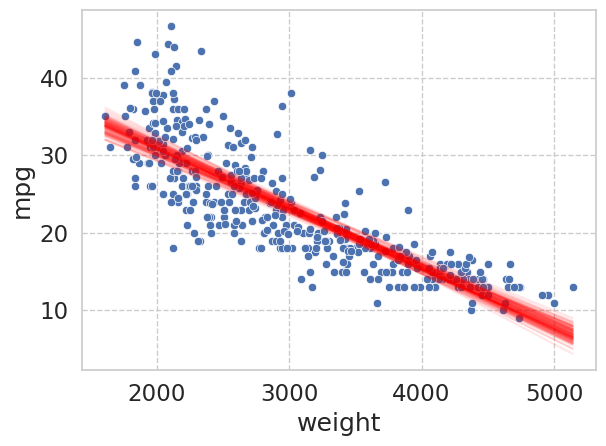

In [7]:
# accuracy of the coefficients
np.random.seed(42)
n_trials = 100

beta_0s, beta_1s = [], []
for _ in tqdm(range(n_trials)):
    sampling_proba = 0.2
    mask = np.random.choice([True, False], size=len(x), p=[sampling_proba, 1 - sampling_proba])
    x_sampled, y_sampled = x[mask], y[mask]
    beta_0, beta_1 = simple_linear_regression(x=x_sampled, y=y_sampled)
    beta_0s.append(beta_0)
    beta_1s.append(beta_1)

# plot the histograms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
sns.histplot(beta_0s, ax=axes[0])
sns.histplot(beta_1s, ax=axes[1])
plt.tight_layout()

# plot the fited lines
plt.figure()
x_range = np.linspace(start=np.min(x), stop=np.max(x), num=100)
for i in tqdm(range(len(beta_0s))):
    sns.lineplot(x=x_range, y=(beta_0s[i] + beta_1s[i] * x_range), color="red", alpha=0.1)
sns.scatterplot(x="weight", y="mpg", data=data)
plt.tight_layout()

In [8]:
# confidence intervals
SE_beta_0 = (np.var(residual, ddof=2) * (1. / len(x) + (np.mean(x))**2 / np.sum((x - np.mean(x))**2)))**0.5
SE_beta_1 = (np.var(residual) / np.sum((x - np.mean(x))**2))**0.5 

print(f"The standard error for beta_0 is: {SE_beta_0:5.4f}")
print(f"The standard error for beta_1 is: {SE_beta_1:5.4f}")

The standard error for beta_0 is: 0.7952
The standard error for beta_1 is: 0.0003


In [9]:
# simple linear regression with the `statsmodels` library
model_1 = smf.ols(formula='mpg ~ weight', data=data)
result_1 = model_1.fit()
print(result_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     888.9
Date:                Sun, 24 Sep 2023   Prob (F-statistic):          2.97e-103
Time:                        01:04:10   Log-Likelihood:                -1148.4
No. Observations:                 398   AIC:                             2301.
Df Residuals:                     396   BIC:                             2309.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.3174      0.795     58.243      0.0

In [10]:
# linear regress in matrix format
X = np.hstack(
    (np.ones(shape=(len(x), 1)), 
     x.to_numpy().reshape(-1, 1)))

# point estimate
beta_matrix = np.linalg.inv(X.T @ X) @ X.T @ y
print("The estimates for beta are:")
print(beta_matrix)

# variance
se_matrix = np.sqrt(np.var(residual, ddof=2) * np.linalg.inv(X.T @ X))
print("\nThe standard error for beta are:")
print(se_matrix)

The estimates for beta are:
[ 4.63173644e+01 -7.67661006e-03]

The standard error for beta are:
[[7.95245230e-01            nan]
 [           nan 2.57486863e-04]]


/tmp/ipykernel_19689/1283480099.py:12: RuntimeWarning: invalid value encountered in sqrt
  se_matrix = np.sqrt(np.var(residual, ddof=2) * np.linalg.inv(X.T @ X))


## Multi-variant linear regression

Multi-variant linear regression is a linear regression that takes more than one independent variable. 

In the following, we will use the Python `statsmodels` library to perform multi-variant linear regression.

In [11]:
model_2 = smf.ols(formula='mpg ~ weight + displacement + horsepower + acceleration', data=data)
result_2 = model_2.fit()
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     233.4
Date:                Sun, 24 Sep 2023   Prob (F-statistic):          9.63e-102
Time:                        01:04:10   Log-Likelihood:                -1120.6
No. Observations:                 392   AIC:                             2251.
Df Residuals:                     387   BIC:                             2271.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       45.2511      2.456     18.424   

In [12]:
# correlation between the continuous variables
data[continuous_variables].corr()

,displacement,horsepower,weight,acceleration
displacement,1.000000,0.897257,0.932824,-0.543684
horsepower,0.897257,1.000000,0.864538,-0.689196
weight,0.932824,0.864538,1.000000,-0.417457
acceleration,-0.543684,-0.689196,-0.417457,1.000000


## One-hot encoding

If the independent variable is of categorical type, we can not directly use them in regression. One-hot encoding is the solution to address this issue. 

At its core, one-hot encoding is about converting nominal categorical data into a format that can be used by machine learning algorithms. Categorical data refers to variables that can be divided into multiple categories but have no order or priority. These categories can be text labels, which many ML algorithms can't work with directly because they expect numerical input features.

With the `statsmodels` library, you simply wrap the independent variable with `C()`. If you are using other libraries, please refer to the corresponding APIs. For example, in the popular `scikit-learn` library, one can [use](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) the `OneHotEncoder` to achieve the same goal.

In [13]:
# one-hot encode the categorical variables
model_3 = smf.ols(formula='mpg ~ weight + C(origin)', data=data)
result_3 = model_3.fit()
print(result_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     308.6
Date:                Sun, 24 Sep 2023   Prob (F-statistic):          4.86e-103
Time:                        01:04:10   Log-Likelihood:                -1142.0
No. Observations:                 398   AIC:                             2292.
Df Residuals:                     394   BIC:                             2308.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           43.6959      1.104  